In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
from scipy.spatial.distance import cdist

In [2]:
def check_neighborhood(point, point_list, max_dist):
    """
    Check if a point is within a certain distance of any point in a list of points.
    
    Parameters
    ----------
    point : tuple
        The point to check.
    point_list : list of tuples
        The list of points to check against.
    dist : float
        The distance threshold.
        
    Returns
    -------
    bool
        True if the point is within the distance threshold of any point in the list, False otherwise
    """
    computed_dist = cdist([point], point_list)[0]
    #print(computed_dist)
    #if computed_dist <= dist:
    if any(d <= max_dist for d in computed_dist):
        return True
    return False


def sitk_jacobian_determinant(deformation):
    '''
    deformation - 3, X, Y, Z, 3
    '''
    deformation = np.transpose(deformation, [1,2,3,0])
    deformation = deformation[:, :, :, [2,1,0]]
    #print(deformation.shape)
    #print(deformation[350, 200, 200, :])
    sitk_displacement_field = sitk.GetImageFromArray(deformation, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayFromImage(jacobian_det_volume)
    #n_count = np.sum(jacobian_det_np_arr < 0)
    return jacobian_det_np_arr


def sitk_jacobian_determinant2(deformation):
    '''
    deformation - 3, X, Y, Z, 3
    '''
    deformation = np.transpose(deformation, [1,2,3,0])
    deformation = deformation[:, :, :, [0, 1, 2]]
    print(deformation.shape)
    #print(deformation[350, 200, 200, :])
    sitk_displacement_field = sitk.GetImageFromArray(deformation, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayFromImage(jacobian_det_volume)
    #n_count = np.sum(jacobian_det_np_arr < 0)
    return jacobian_det_np_arr


def compute_jacobian_determinant(deformation, coord, debug=False):
    """
    Compute the Jacobian determinant at a specific point in the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - coord: The coordinates of the point (z, y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    #print(coord)
    
    z, y, x = coord
    #print(deformation.shape)
    #print(deformation[0, z, y, x + 1])

    # Compute the partial derivatives
    dFx_dx = (deformation[2, z, y, x + 1] - deformation[2, z, y, x - 1]) / 2
    dFx_dy = (deformation[2, z, y + 1, x] - deformation[2, z, y - 1, x]) / 2
    dFx_dz = (deformation[2, z + 1, y, x] - deformation[2, z - 1, y, x]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (deformation[1, z, y, x + 1] - deformation[1, z, y, x - 1]) / 2
    dFy_dy = (deformation[1, z, y + 1, x] - deformation[1, z, y - 1, x]) / 2
    dFy_dz = (deformation[1, z + 1, y, x] - deformation[1, z - 1, y, x]) / 2

    dFz_dx = (deformation[0, z, y, x + 1] - deformation[0, z, y, x - 1]) / 2
    dFz_dy = (deformation[0, z, y + 1, x] - deformation[0, z, y - 1, x]) / 2
    dFz_dz = (deformation[0, z + 1, y, x] - deformation[0, z - 1, y, x]) / 2
    
    """
    dFx_dx = (deformation[0, z, y, x + 1] - deformation[0, z, y, x - 1]) / 2
    dFx_dy = (deformation[0, z, y + 1, x] - deformation[0, z, y - 1, x]) / 2
    dFx_dz = (deformation[0, z + 1, y, x] - deformation[0, z - 1, y, x]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (deformation[1, z, y, x + 1] - deformation[1, z, y, x - 1]) / 2
    dFy_dy = (deformation[1, z, y + 1, x] - deformation[1, z, y - 1, x]) / 2
    dFy_dz = (deformation[1, z + 1, y, x] - deformation[1, z - 1, y, x]) / 2

    dFz_dx = (deformation[2, z, y, x + 1] - deformation[2, z, y, x - 1]) / 2
    dFz_dy = (deformation[2, z, y + 1, x] - deformation[2, z, y - 1, x]) / 2
    dFz_dz = (deformation[2, z + 1, y, x] - deformation[2, z - 1, y, x]) / 2
    """

    # Form the Jacobian matrix
    # Note that the determinant of a zero vector field is also zero, whereas the Jacobian determinant of the corresponding identity warp transformation is 1.0. 
    # In order to compute the effective deformation Jacobian determinant 1.0 must be added to the diagonal elements of Jacobian prior to taking the derivative. 
    # i.e. det([ (1.0+dx/dx) dx/dy dx/dz ; dy/dx (1.0+dy/dy) dy/dz; dz/dx dz/dy (1.0+dz/dz) ])
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy, dFx_dz],
        [dFy_dx, dFy_dy + 1, dFy_dz],
        [dFz_dx, dFz_dy, dFz_dz + 1]
    ])
    
    if debug:
        print("Determinant computation at point:", coord)
        print("dFx/dx + 1:", dFx_dx + 1)
        print("\t(" + str(deformation[2, z, y, x + 1]) + " - " + str(deformation[2, z, y, x - 1]) + ") / 2 + 1")
        print("dFy/dy + 1:", dFy_dy + 1)
        print("\t(" + str(deformation[1, z, y + 1, x]) + " - " + str(deformation[1, z, y - 1, x]) + ") / 2 + 1")
        print("dFx/dy:", dFx_dy)
        print("\t" + str(deformation[2, z, y + 1, x]) + " - " + str(deformation[2, z, y - 1, x]) + ") / 2")
        print("dFy/dx:", dFy_dx)
        print("\t(" + str(deformation[1, z, y, x + 1]) + " - " + str(deformation[1, z, y, x - 1]) + ") / 2")
        
        print("(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)")
        print("\t" + str(dFx_dx + 1) + " * " + str(dFy_dy + 1) + " - " + str(dFx_dy) + " * " + str(dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1)) + " - " + str(dFx_dy * dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1) - dFx_dy * dFy_dx))
        print("Jacobian")
        print(jacobian_matrix)

    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det


def compute_jacobian_determinant_volume(deformation):
    """
    Compute the Jacobian determinant volume from the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    
    Returns:
    - jacobian_determinant_volume: The Jacobian determinant volume.
    """
    # Initialize the Jacobian determinant volume
    jacobian_determinant_volume = np.zeros(deformation.shape[1:])
    print(deformation.shape)
    

    # Iterate over all voxels in the deformation field
    # (Skip boundaries, haven't written those edge cases yet)
    for z in tqdm(range(1, deformation.shape[1] - 1)):
        for y in range(1, deformation.shape[2] - 1):
            for x in range(1, deformation.shape[3] - 1):
                # Compute the Jacobian determinant at the current point
                jacobian_determinant_volume[z, y, x] = compute_jacobian_determinant(deformation, (z, y, x))

    return jacobian_determinant_volume


def surrounding_points(coord: tuple, deformation: np.ndarray, jacobian_det: np.ndarray):
    """
    Print out the surrounding points of a specific coordinate in the deformation field
    along with their displacement vectors and Jacobian determinants.
    
    Parameters:
    - coord: The coordinate of the point (z, y, x).
    - deformation: The deformation field (3D vector field).
    - jacobian_det: The Jacobian determinant volume.
    """
    curr_coord = coord
    # Get the coordinates of the surrounding points
    curr_coord_up = (curr_coord[0], curr_coord[1] - 1, curr_coord[2])
    curr_coord_down = (curr_coord[0], curr_coord[1] + 1, curr_coord[2])
    curr_coord_left = (curr_coord[0], curr_coord[1], curr_coord[2] - 1)
    curr_coord_right = (curr_coord[0], curr_coord[1], curr_coord[2] + 1)
    curr_coord_prev = (curr_coord[0] - 1, curr_coord[1], curr_coord[2])
    curr_coord_next = (curr_coord[0] + 1, curr_coord[1], curr_coord[2])

    # Get the displacement vectors
    curr_vector = deformation[:, curr_coord[0], curr_coord[1], curr_coord[2]]
    left_vector = deformation[:, curr_coord_left[0], curr_coord_left[1], curr_coord_left[2]]
    right_vector = deformation[:, curr_coord_right[0], curr_coord_right[1], curr_coord_right[2]]
    up_vector = deformation[:, curr_coord_up[0], curr_coord_up[1], curr_coord_up[2]]
    down_vector = deformation[:, curr_coord_down[0], curr_coord_down[1], curr_coord_down[2]]
    prev_vector = deformation[:, curr_coord_prev[0], curr_coord_prev[1], curr_coord_prev[2]]
    next_vector = deformation[:, curr_coord_next[0], curr_coord_next[1], curr_coord_next[2]]

    # Get the jacobian determinants
    curr_det = jacobian_det[curr_coord[0], curr_coord[1], curr_coord[2]]
    left_det = jacobian_det[curr_coord_left[0], curr_coord_left[1], curr_coord_left[2]]
    right_det = jacobian_det[curr_coord_right[0], curr_coord_right[1], curr_coord_right[2]]
    up_det = jacobian_det[curr_coord_up[0], curr_coord_up[1], curr_coord_up[2]]
    down_det = jacobian_det[curr_coord_down[0], curr_coord_down[1], curr_coord_down[2]]
    prev_det = jacobian_det[curr_coord_prev[0], curr_coord_prev[1], curr_coord_prev[2]]
    next_det = jacobian_det[curr_coord_next[0], curr_coord_next[1], curr_coord_next[2]]

    # Print out information
    print("Current point:", curr_coord)
    print("Displacement vectors (z, y, x)")
    print("CURRENT point - Displacement vector at", curr_coord, ":\t\t", curr_vector)
    print("\t\tNew position:", curr_coord + curr_vector)
    print("\tLeft displacement vector at", curr_coord_left, ":\t\t\t", left_vector)
    print("\t\tNew position:", curr_coord_left + left_vector)
    print("\tRight displacement vector at", curr_coord_right, ":\t\t\t", right_vector)
    print("\t\tNew position:", curr_coord_right + right_vector)
    print("\tUp displacement vector at", curr_coord_up, ":\t\t\t", up_vector)
    print("\t\tNew position:", curr_coord_up + up_vector)
    print("\tDown displacement vector at", curr_coord_down, ":\t\t\t", down_vector)
    print("\t\tNew position:", curr_coord_down + down_vector)
    #print("\tPrevious section displacement vector at", curr_coord_prev, ":\t", prev_vector)
    #print("\t\tNew position:", curr_coord_prev + prev_vector)
    #print("\tNext section displacement vector at", curr_coord_next, ":\t\t", next_vector)
    #print("\t\tNew position:", curr_coord_next + next_vector)

    print("\nDeterminants")
    print("CURRENT point - Jacobian determinant at", curr_coord, ":\t\t", curr_det)
    print("\tLeft Jacobian determinant at", curr_coord_left, ":\t\t\t", left_det)
    print("\tRight Jacobian determinant at", curr_coord_right, ":\t\t\t", right_det)
    print("\tUp Jacobian determinant at", curr_coord_up, ":\t\t\t", up_det)
    print("\tDown Jacobian determinant at", curr_coord_down, ":\t\t\t", down_det)
    #print("\tPrevious section Jacobian determinant at", curr_coord_prev, ":\t", prev_det)
    #print("\tNext section Jacobian determinant at", curr_coord_next, ":\t\t", next_det)

Load deformation field

In [3]:
# Input parameters
CURR_IDX = 350
base_path = "data/base/registered_output/deformation3d.npy"
base_mpoints = "data/base/mpoints.npy"
base_fpoints = "data/base/fpoints.npy"
corrected_path = "data/corrected_correspondences/registered_output/deformation3d.npy"
corrected_mpoints = "data/corrected_correspondences/new_mcorrespondences.npy"
corrected_fpoints = "data/corrected_correspondences/new_fcorrespondences.npy"

# Load the numpy array and compute the jacobian determinant
base_deformation = np.load(base_path)
base_jacobian_det_sitk = sitk_jacobian_determinant(base_deformation)
#base_jacobian_det_manual = compute_jacobian_determinant_volume(base_deformation)  # Verify if this is correct with SITK's implementation, appears to match

corrected_mpoints = np.load(corrected_mpoints)
corrected_fpoints = np.load(corrected_fpoints)
corrected_deformation = np.load(corrected_path)  # Recompute for the corrected deformation
corrected_jacobian_det_sitk = sitk_jacobian_determinant(corrected_deformation)
#corrected_jacobian_det_manual = compute_jacobian_determinant_volume(corrected_deformation)  # Verify if this is correct with SITK's implementation, appears to match

print("Shape of jacobian determinant volume:", corrected_jacobian_det_sitk.shape)

# Print the coordinates
negative_coordinates = np.argwhere(base_jacobian_det_sitk[CURR_IDX] < 0)
negative_coordinates_list = [tuple(coord) for coord in negative_coordinates]
print(f"Base count of negative values in section {CURR_IDX}:", len(negative_coordinates_list), "/", base_jacobian_det_sitk[CURR_IDX].shape[0] * base_jacobian_det_sitk[CURR_IDX].shape[1])
print("\tBase percentage of negative values in section:", len(negative_coordinates_list) / (base_jacobian_det_sitk[CURR_IDX].shape[0] * base_jacobian_det_sitk[CURR_IDX].shape[1]) * 100)

negative_coordinates_vol = np.argwhere(base_jacobian_det_sitk < 0)
negative_coordinates_list_vol = [tuple(coord) for coord in negative_coordinates_vol]
print(f"Base count of negative values in volume:", len(negative_coordinates_list_vol), "/", base_jacobian_det_sitk.shape[0] * base_jacobian_det_sitk.shape[1] * base_jacobian_det_sitk.shape[2])
print("\tBase percentage of negative values in volume:", len(negative_coordinates_list_vol) / (base_jacobian_det_sitk.shape[0] * base_jacobian_det_sitk.shape[1] * base_jacobian_det_sitk.shape[2]) * 100)

negative_coordinates = np.argwhere(corrected_jacobian_det_sitk[CURR_IDX] < 0)
negative_coordinates_list = [tuple(coord) for coord in negative_coordinates]
print(f"Count of negative values in section {CURR_IDX}:", len(negative_coordinates_list), "/", corrected_jacobian_det_sitk[CURR_IDX].shape[0] * corrected_jacobian_det_sitk[CURR_IDX].shape[1])
print("\tPercentage of negative values in section:", len(negative_coordinates_list) / (corrected_jacobian_det_sitk[CURR_IDX].shape[0] * corrected_jacobian_det_sitk[CURR_IDX].shape[1]) * 100)

negative_coordinates_vol = np.argwhere(corrected_jacobian_det_sitk < 0)
negative_coordinates_list_vol = [tuple(coord) for coord in negative_coordinates_vol]
print(f"Count of negative values in volume:", len(negative_coordinates_list_vol), "/", corrected_jacobian_det_sitk.shape[0] * corrected_jacobian_det_sitk.shape[1] * corrected_jacobian_det_sitk.shape[2])
print("\tPercentage of negative values in volume:", len(negative_coordinates_list_vol) / (corrected_jacobian_det_sitk.shape[0] * corrected_jacobian_det_sitk.shape[1] * corrected_jacobian_det_sitk.shape[2]) * 100)

Shape of jacobian determinant volume: (528, 320, 456)
Base count of negative values in section 350: 846 / 145920
	Base percentage of negative values in section: 0.5797697368421052
Base count of negative values in volume: 406478 / 77045760
	Base percentage of negative values in volume: 0.5275799732522594
Count of negative values in section 350: 286 / 145920
	Percentage of negative values in section: 0.19599780701754385
Count of negative values in volume: 155717 / 77045760
	Percentage of negative values in volume: 0.2021097591872674


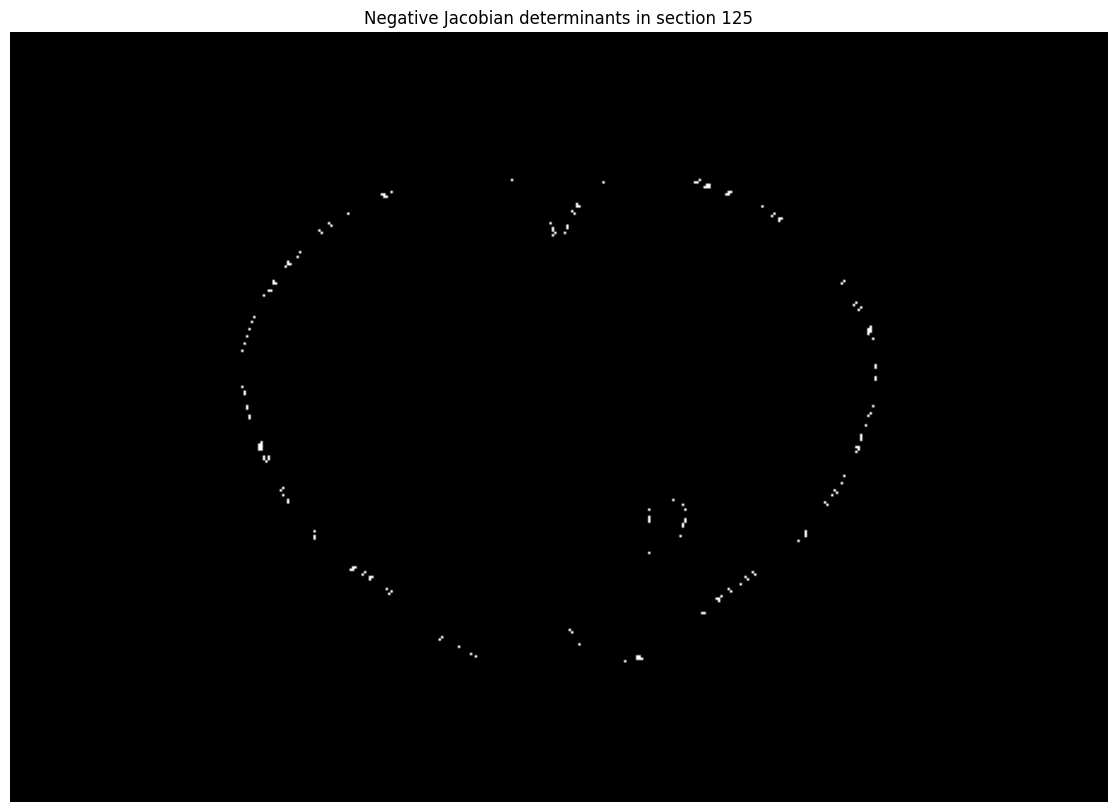

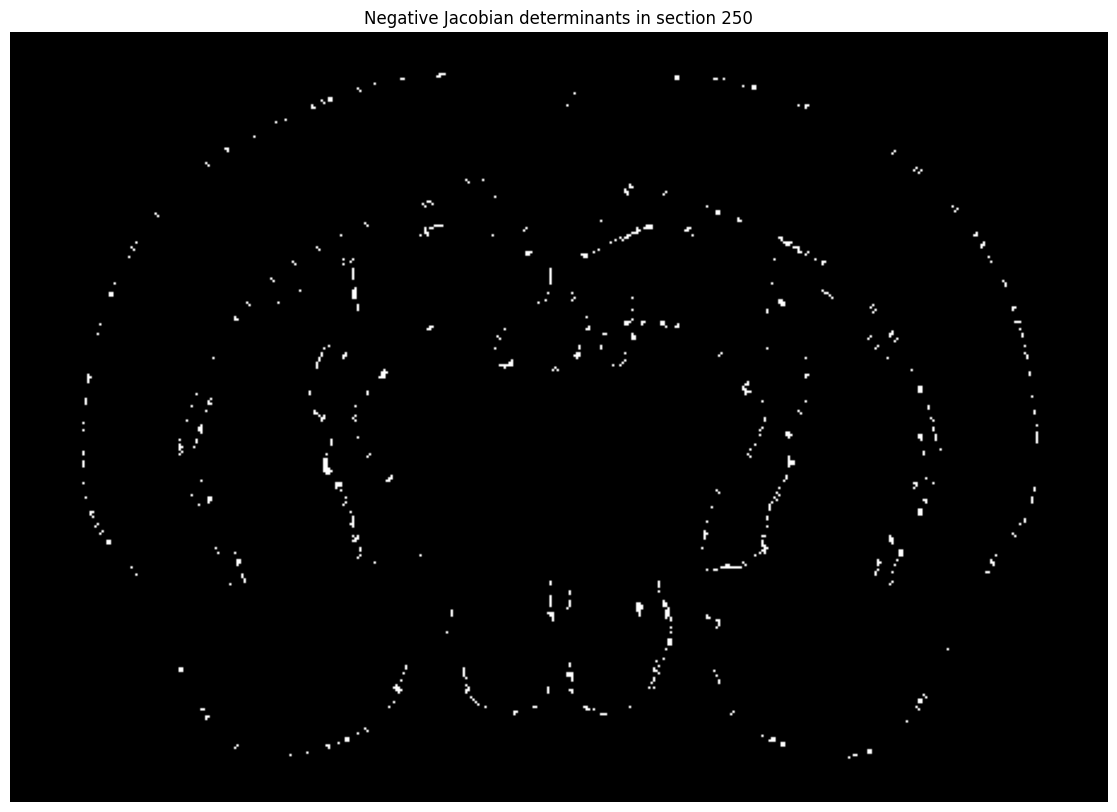

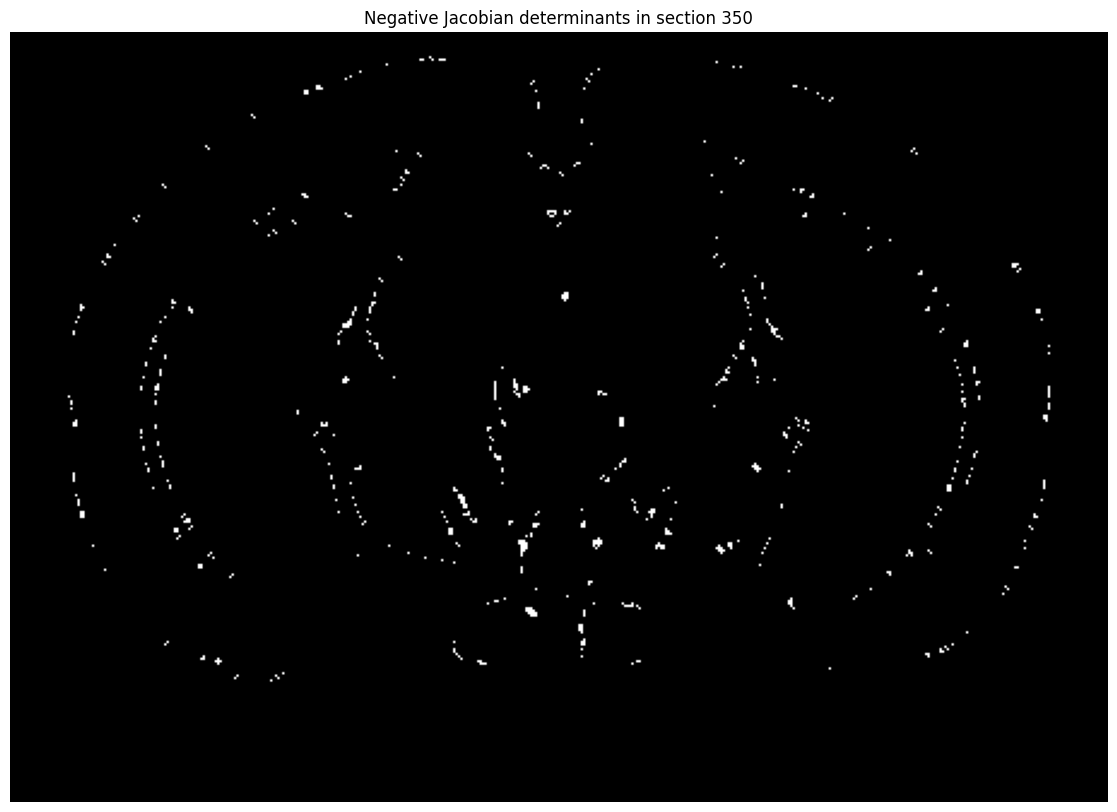

In [4]:
indices = [125, 250, 350]
#base_jacobian_det_sitk[base_jacobian_det_sitk > 0] = 0
#base_jacobian_det_sitk[base_jacobian_det_sitk < 0] = 1
#corrected_jacobian_det_sitk[corrected_jacobian_det_sitk > 0] = 0
#corrected_jacobian_det_sitk[corrected_jacobian_det_sitk < 0] = 1
#base_jacobian_det_sitk = base_jacobian_det_sitk.astype(bool)
#corrected_jacobian_det_sitk = corrected_jacobian_det_sitk.astype(bool)
for CURR_IDX in indices:
    # Show the section with its negative jacobian determinants
    plt.figure(figsize=(15, 10))
    plt.imshow(base_jacobian_det_sitk[CURR_IDX] < 0, cmap='gray')
    plt.title("Negative Jacobian determinants in section " + str(CURR_IDX), fontsize=12)
    plt.axis('off')
    plt.show()

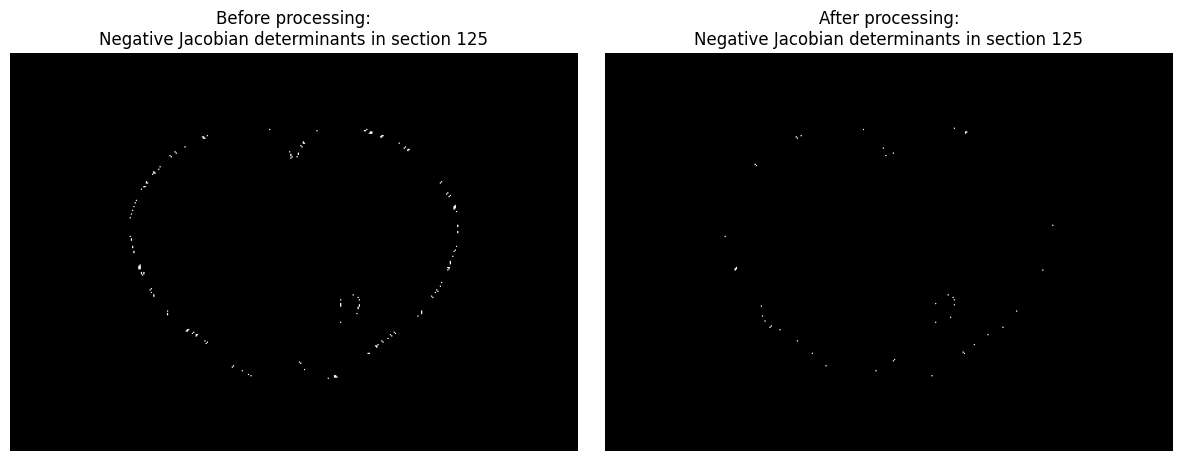

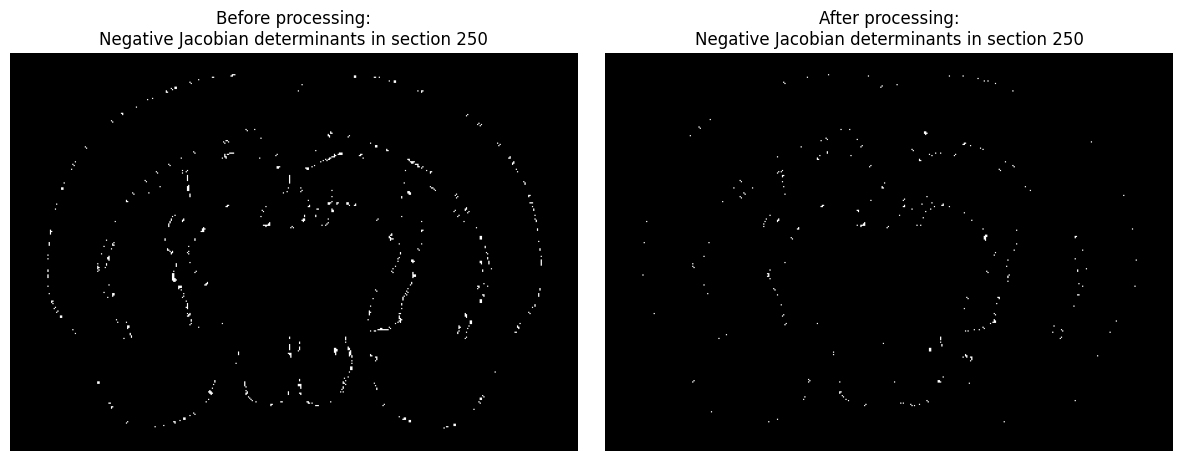

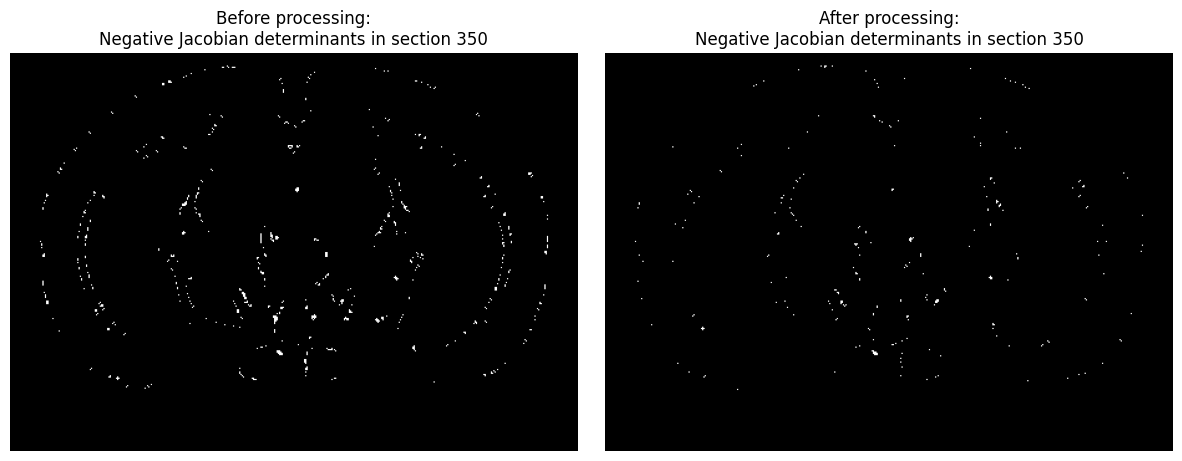

In [44]:
indices = [125, 250, 350]
#base_jacobian_det_sitk[base_jacobian_det_sitk > 0] = 0
#base_jacobian_det_sitk[base_jacobian_det_sitk < 0] = 1
#corrected_jacobian_det_sitk[corrected_jacobian_det_sitk > 0] = 0
#corrected_jacobian_det_sitk[corrected_jacobian_det_sitk < 0] = 1
#base_jacobian_det_sitk = base_jacobian_det_sitk.astype(bool)
#corrected_jacobian_det_sitk = corrected_jacobian_det_sitk.astype(bool)
for CURR_IDX in indices:
    # Show the section with its negative jacobian determinants
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(base_jacobian_det_sitk[CURR_IDX] < 0, cmap='gray')
    plt.title("Before processing:\nNegative Jacobian determinants in section " + str(CURR_IDX), fontsize=12)
    plt.axis('off')
    
    
    # Show the section with its negative jacobian determinants
    plt.subplot(1, 2, 2)
    plt.imshow(corrected_jacobian_det_sitk[CURR_IDX] < 0, cmap='gray')
    plt.title("After processing:\nNegative Jacobian determinants in section " + str(CURR_IDX), fontsize=12)
    plt.axis('off')
    
    plt.subplots_adjust(wspace=0.05)  # Adjust wspace to control the horizontal gap
    plt.show()

Show information about a coordinate with negative Jacobian

Current point: (350, 179, 309)
Displacement vectors (z, y, x)
CURRENT point - Displacement vector at (350, 179, 309) :		 [ 0.          5.72181793 -4.88819129]
		New position: [350.         184.72181793 304.11180871]
	Left displacement vector at (350, 179, 308) :			 [ 0.          4.47871895 -3.55779294]
		New position: [350.         183.47871895 304.44220706]
	Right displacement vector at (350, 179, 310) :			 [ 0.          8.99979251 -8.00018575]
		New position: [350.         187.99979251 301.99981425]
	Up displacement vector at (350, 178, 309) :			 [ 0.          4.93774832 -4.18207541]
		New position: [350.         182.93774832 304.81792459]
	Down displacement vector at (350, 180, 309) :			 [ 0.          5.38360637 -4.59159548]
		New position: [350.         185.38360637 304.40840452]

Determinants
CURRENT point - Jacobian determinant at (350, 179, 309) :		 -1.0305689441393375
	Left Jacobian determinant at (350, 179, 308) :			 0.03963349196986317
	Right Jacobian determinant at (350, 179

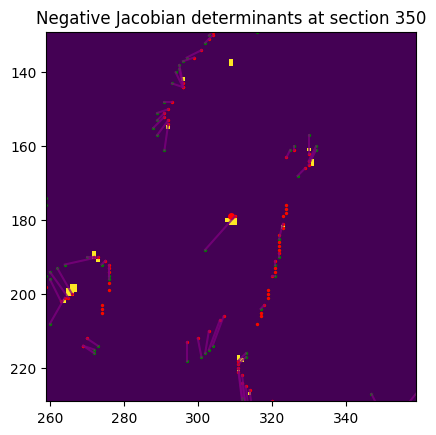

Number of matches: 509 / 1319


In [42]:
# Focus on a specific coordinate
y, x = 179, 309

# Print the surrounding points of that coordinate
curr_coord = (CURR_IDX, y, x)
surrounding_points(curr_coord, corrected_deformation, corrected_jacobian_det_sitk)

print()
coord_det = compute_jacobian_determinant(corrected_deformation, curr_coord, debug=True)
print("Jacobian determinant at", curr_coord, ":", coord_det)

# Show the section with negative jacobian determinants
plt.imshow(corrected_jacobian_det_sitk[CURR_IDX] < 0, cmap='viridis')
plt.title("Negative Jacobian determinants at section " + str(CURR_IDX))
plt.xlim(x - 50, x + 50)
plt.ylim(y - 50, y + 50)
plt.plot(curr_coord[2], curr_coord[1], 'ro', markersize=4, alpha=1)

# Show all points
mpts = corrected_mpoints[corrected_mpoints[:, 0] == CURR_IDX][:, 1:]
fpts = corrected_fpoints[corrected_fpoints[:, 0] == CURR_IDX][:, 1:]
plt.scatter( mpts[:,1], mpts[:,0], color='green', s=2)
plt.scatter( fpts[:,1], fpts[:,0], color='red', s=2)
for i in range(len(mpts)):
    plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='purple', alpha=0.75)

plt.gca().invert_yaxis()
plt.show()

# Count the number of matches
num_matches = 0
for fpt in fpts:
    if check_neighborhood(tuple(fpt), negative_coordinates_list, 5):
        num_matches += 1
print("Number of matches:", num_matches, "/", len(fpts))

Get only points from section 350

In [7]:
def remove_duplicates(list1: np.ndarray, list2: np.ndarray):
    """
    Remove duplicate elements from list1 and the corresponding elements from list2.
    
    Parameters:
    - list1: The first list from which duplicates will be removed.
    - list2: The second list from which elements will be removed corresponding to the removed elements in list1.
    
    Returns:
    - list1_unique: The list1 with duplicates removed.
    - list2_filtered: The list2 with elements removed corresponding to the removed elements in list1.
    """
    seen = set()
    list1_unique = []
    list2_filtered = []
    
    for item1, item2 in zip(list1, list2):
        item1_tuple = tuple(item1)
        if item1_tuple not in seen:
            seen.add(item1_tuple)
            list1_unique.append(item1)
            list2_filtered.append(item2)
    
    return np.array(list1_unique), np.array(list2_filtered)

mpts350 = np.array([item for item in corrected_mpoints if item[0] == 350])
fpts350 = np.array([item for item in corrected_fpoints if item[0] == 350])

mpts3502, fpts3502 = remove_duplicates(mpts350, fpts350)
fpts3502, mpts3502 = remove_duplicates(fpts3502, mpts3502)
print(mpts350.shape)
print(fpts350.shape)
print(mpts3502.shape)
print(fpts3502.shape)

np.save("data/corrected_correspondences/mpts_350_2.npy", mpts350)
np.save("data/corrected_correspondences/fpts_350_2.npy", fpts350)

(1319, 3)
(1319, 3)
(1269, 3)
(1269, 3)


import numpy as np

def compute_jacobian_determinant_2d(deformation, coord):
    """
    Compute the Jacobian determinant at a specific point in the 2D deformation field.
    
    Parameters:
    - deformation: The deformation field (2D vector field).
    - coord: The coordinates of the point (y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    z, y, x = coord

    # Compute the partial derivatives
    dFx_dx = (deformation[2, z, y, x + 1] - deformation[2, z, y, x - 1]) / 2
    dFx_dy = (deformation[2, z, y + 1, x] - deformation[2, z, y - 1, x]) / 2

    dFy_dx = (deformation[1, z, y, x + 1] - deformation[1, z, y, x - 1]) / 2
    dFy_dy = (deformation[1, z, y + 1, x] - deformation[1, z, y - 1, x]) / 2

    # Form the Jacobian matrix
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy],
        [dFy_dx, dFy_dy + 1]
    ])
    #print(jacobian_matrix)
    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det

jacobian_det = compute_jacobian_determinant_2d(deformation, curr_coord)
print("Jacobian determinant at", curr_coord, ":", jacobian_det)

jacobian_2d = np.zeros((320, 456))
for y in tqdm(range(1, 319)):
    for x in range(1, 455):
        jacobian_2d[y, x] = compute_jacobian_determinant_2d(deformation, (CURR_IDX, y, x))
        
plt.imshow(jacobian_2d < 0, cmap='viridis')
plt.title("Negative Jacobian determinants at section " + str(CURR_IDX))
plt.show()

CURR_IDX = 350

# Set the npy filepath with the jacobian determinant values
base_npy_path = '10-30-24 invertibility analysis/registered_output/deformation3d.npy'

# Load the numpy array
base_deformation = np.load(base_npy_path)

base_jacobian_2d = np.zeros((320, 456))
for y in tqdm(range(1, 319)):
    for x in range(1, 455):
        base_jacobian_2d[y, x] = compute_jacobian_determinant_2d(base_deformation, (CURR_IDX, y, x))
        
plt.imshow(base_jacobian_2d < 0, cmap='viridis')
plt.title("Negative Jacobian determinants at section " + str(CURR_IDX))
plt.show()

Check 2D library Jacobian

jacobian_arr1 = get_jacobian_determinant(deformation)

deformation2 = np.transpose(deformation, [1,2,3,0])
deformation2 = deformation2[350, :, :, 1:]
print(deformation2.shape)
sitk_displacement_field = sitk.GetImageFromArray(deformation2, isVector=True)
jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
jacobian_det_np_arr = sitk.GetArrayFromImage(jacobian_det_volume)

plt.imshow(jacobian_det_np_arr < 0, cmap='viridis')
plt.title("2D Negative Jacobian determinants at section " + str(CURR_IDX))
plt.show()

plt.imshow(jacobian_arr1[350] < 0, cmap='viridis')
plt.title("3D Negative Jacobian determinants at section " + str(CURR_IDX))
plt.show()